In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "../")
from scipy.ndimage import convolve1d
from scipy.interpolate import interp1d
import optax 
from optax.schedules import warmup_cosine_decay_schedule

from src.kernel import GaussKernel,VFTSGaussKernel,TSGaussGaussKernel,TSGaussDotKernel
from src.lddmm import Shooting,VarifoldLoss,batch_one_to_many_registration
from src.barycenter import batch_iterated_barycenter_registration,batch_barycenter_registration
from src.utils import from_timeseries_to_dataset, batch_dataset


In [2]:
Kv = VFTSGaussKernel(1,0.1,65,1,1)
Kl = TSGaussGaussKernel(5,1,1,1)
loss = VarifoldLoss(Kl)

iteration:  1 / 400  -- loss:  1191.91
iteration:  10 / 400  -- loss:  973.76
iteration:  20 / 400  -- loss:  466.89
iteration:  30 / 400  -- loss:  247.75
iteration:  40 / 400  -- loss:  113.06
iteration:  50 / 400  -- loss:  56.63
iteration:  60 / 400  -- loss:  28.45
iteration:  70 / 400  -- loss:  15.64
iteration:  80 / 400  -- loss:  11.14
iteration:  90 / 400  -- loss:  8.72
iteration:  100 / 400  -- loss:  7.44
...Updating barycenter...
iteration:  110 / 400  -- loss:  10.99
iteration:  120 / 400  -- loss:  7.36
iteration:  130 / 400  -- loss:  6.34
iteration:  140 / 400  -- loss:  5.75
iteration:  150 / 400  -- loss:  5.44
iteration:  160 / 400  -- loss:  5.20
iteration:  170 / 400  -- loss:  4.97
iteration:  180 / 400  -- loss:  4.79
iteration:  190 / 400  -- loss:  4.63
iteration:  200 / 400  -- loss:  4.49
...Updating barycenter...
iteration:  210 / 400  -- loss:  4.34
iteration:  220 / 400  -- loss:  4.17
iteration:  230 / 400  -- loss:  4.03
iteration:  240 / 400  -- loss:

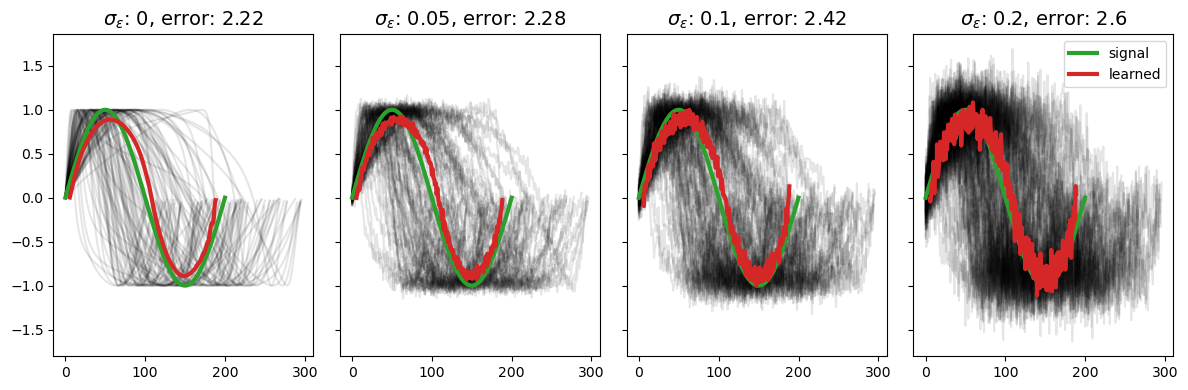

In [3]:
noise_ratio = [0,0.05,0.1,0.2]


fig,axs = plt.subplots(1,4,figsize=(12,4),sharey=True)
for i,r in enumerate(noise_ratio):

    bX_mask = np.load("dataset/Xmask.npy")
    bX = np.load(f"dataset/X_{int(r*100)}.npy")

    pst,qt,qtmask = batch_iterated_barycenter_registration(bX,bX_mask,Kv,loss,niter=400,update_interval=100,optimizer = optax.adabelief(warmup_cosine_decay_schedule(0,0.1,40,400,0)),gamma_loss=1e-3)

    time = np.linspace(0,1,np.sum(qtmask))
    signal = np.sin(2*np.pi*time)
    for x,xmask in zip(bX.squeeze(),bX_mask.squeeze()):
        fi = x[xmask.squeeze(),:]
        axs[i].plot(*fi.T,color = "black",alpha = 0.1)

    axs[i].plot(time*200,signal,color="tab:green",label="signal",linewidth=3)
    axs[i].plot(*qt[qtmask.squeeze()].T,color="tab:red",label="learned",linewidth=3)
    err = signal-qt[qtmask.squeeze()][:,1]
    axs[i].set_title(r"$\sigma_{\epsilon}$"+f": {np.around(r,2)}" + f", error: {np.around(float(np.linalg.norm(err)),2)}" ,fontsize=14)

    if i == len(noise_ratio)-1: 
        axs[i].legend()

fig.tight_layout()
fig.savefig("results/tslddmm_barycenter.svg")
    
    

In [4]:
fig.set_figwidth(12)
fig.set_figheight(2.5)
fig.tight_layout()
fig.savefig("tslddmm_barycenter.jpeg",format = "jpeg")